<a href="https://colab.research.google.com/github/shibusangma/Ordersystem/blob/main/Canteen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# canteen_app.py
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import io
import base64
from PIL import Image

# Set page config
st.set_page_config(
    page_title="Canteen Ordering System",
    page_icon="🍔",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# App title and description
st.title("🍔 Canteen Ordering System")
st.markdown("Analyze sales patterns, popular items, and customer behavior in a canteen setting")

# Menu items with categories and prices
menu_items = {
    'Burger': {'category': 'Main Course', 'price': 5.99},
    'Pizza': {'category': 'Main Course', 'price': 7.50},
    'Sandwich': {'category': 'Main Course', 'price': 4.50},
    'Salad': {'category': 'Main Course', 'price': 6.25},
    'French Fries': {'category': 'Side', 'price': 2.99},
    'Onion Rings': {'category': 'Side', 'price': 3.25},
    'Soda': {'category': 'Beverage', 'price': 1.99},
    'Coffee': {'category': 'Beverage', 'price': 2.25},
    'Tea': {'category': 'Beverage', 'price': 1.75},
    'Water': {'category': 'Beverage', 'price': 1.00}
}

def generate_canteen_data(days=30):
    """Generate simulated canteen order data"""
    # Generate orders
    orders = []
    order_id = 1000
    start_date = datetime.now() - timedelta(days=days)

    for day in range(days):
        current_date = start_date + timedelta(days=day)

        # More orders during lunch hours (11 AM - 2 PM)
        for hour in range(8, 20):  # 8 AM to 8 PM
            hour_probability = 0.3  # Base probability
            if 11 <= hour < 14:  # Lunch rush
                hour_probability = 0.8

            # Generate orders for this hour
            num_orders = np.random.poisson(10 * hour_probability)

            for _ in range(num_orders):
                order_time = current_date + timedelta(
                    hours=hour,
                    minutes=np.random.randint(0, 60)
                )

                # Select random items
                num_items = np.random.randint(1, 5)
                items = random.sample(list(menu_items.keys()), num_items)

                for item in items:
                    orders.append({
                        'order_id': order_id,
                        'date': order_time.date(),
                        'time': order_time.time(),
                        'day_of_week': order_time.strftime('%A'),
                        'hour': hour,
                        'item': item,
                        'category': menu_items[item]['category'],
                        'price': menu_items[item]['price'],
                        'quantity': np.random.randint(1, 4)
                    })

                order_id += 1

    # Create DataFrame
    df = pd.DataFrame(orders)
    df['revenue'] = df['price'] * df['quantity']

    return df

def analyze_customer_behavior(df):
    """Analyze customer ordering behavior"""
    # Average order value
    order_totals = df.groupby('order_id')['revenue'].sum()
    avg_order_value = order_totals.mean()

    # Items per order
    items_per_order = df.groupby('order_id')['quantity'].sum().mean()

    # Popular combinations (simplified)
    order_groups = df.groupby('order_id')['item'].apply(list)
    item_cooccurrence = {}

    for items in order_groups:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                pair = tuple(sorted([items[i], items[j]]))
                item_cooccurrence[pair] = item_cooccurrence.get(pair, 0) + 1

    top_pairs = sorted(item_cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]

    return {
        'avg_order_value': avg_order_value,
        'items_per_order': items_per_order,
        'top_combinations': top_pairs
    }

def create_visualizations(df):
    """Create visualizations of the canteen data"""
    # Create a 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Canteen Sales Analysis', fontsize=16)

    # 1. Revenue by day of week
    daily_revenue = df.groupby('day_of_week')['revenue'].sum()
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_revenue = daily_revenue.reindex(days)
    axes[0, 0].bar(daily_revenue.index, daily_revenue.values)
    axes[0, 0].set_title('Total Revenue by Day of Week')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Most popular items
    popular_items = df.groupby('item')['quantity'].sum().sort_values(ascending=False).head(5)
    axes[0, 1].barh(list(popular_items.index), popular_items.values)
    axes[0, 1].set_title('Top 5 Most Popular Items')
    axes[0, 1].set_xlabel('Quantity Sold')

    # 3. Sales by hour
    hourly_sales = df.groupby('hour')['revenue'].sum()
    axes[1, 0].plot(hourly_sales.index, hourly_sales.values, marker='o')
    axes[1, 0].set_title('Revenue by Hour of Day')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Revenue')
    axes[1, 0].set_xticks(range(8, 20))

    # 4. Revenue by category
    category_revenue = df.groupby('category')['revenue'].sum()
    axes[1, 1].barh(list(category_revenue.index), category_revenue.values)
    axes[1, 1].set_title('Revenue by Category')
    axes[1, 1].set_xlabel('Revenue')

    plt.tight_layout()
    return fig

def prepare_download_data(df):
    """Prepare data for download"""
    # Create additional aggregated datasets
    daily_summary = df.groupby('date').agg({
        'order_id': 'nunique',
        'revenue': 'sum',
        'quantity': 'sum'
    }).reset_index()
    daily_summary.rename(columns={'order_id': 'orders_count'}, inplace=True)

    # Category daily performance
    category_daily = df.groupby(['date', 'category']).agg({
        'revenue': 'sum',
        'quantity': 'sum'
    }).reset_index()

    # Item performance
    item_performance = df.groupby('item').agg({
        'revenue': 'sum',
        'quantity': 'sum',
        'order_id': 'nunique'
    }).reset_index()
    item_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

    # Hourly performance
    hourly_performance = df.groupby('hour').agg({
        'revenue': 'sum',
        'order_id': 'nunique',
        'quantity': 'sum'
    }).reset_index()
    hourly_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

    return {
        'orders': df,
        'daily_summary': daily_summary,
        'category_daily': category_daily,
        'item_performance': item_performance,
        'hourly_performance': hourly_performance
    }

# Sidebar for navigation
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", ["Home", "Data Generator", "Visualizations", "Customer Analysis", "Data Export"])

# Initialize session state for data
if 'canteen_data' not in st.session_state:
    st.session_state.canteen_data = None

# Home page
if page == "Home":
    st.header("Welcome to the Canteen Ordering System")

    col1, col2, col3 = st.columns(3)

    with col1:
        st.subheader("📊 Data Analysis")
        st.markdown("""
        - Generate simulated canteen order data
        - Analyze sales patterns and trends
        - Identify popular items and categories
        """)

    with col2:
        st.subheader("📈 Visualizations")
        st.markdown("""
        - Interactive charts and graphs
        - Revenue analysis by time and category
        - Customer behavior insights
        """)

    with col3:
        st.subheader("💾 Data Export")
        st.markdown("""
        - Export data for further analysis
        - Prepare data for Power BI dashboards
        - Download CSV files for reporting
        """)

    st.markdown("---")
    st.subheader("How to Use This App")
    st.markdown("""
    1. Go to the **Data Generator** page to create sample data
    2. View **Visualizations** to explore patterns and trends
    3. Check **Customer Analysis** for behavioral insights
    4. Use **Data Export** to download data for further analysis
    """)

    st.markdown("---")
    st.subheader("About This Project")
    st.markdown("""
    This canteen ordering system demonstrates data analysis and visualization skills using:
    - Python
    - Streamlit for the web interface
    - Pandas for data manipulation
    - Seaborn and Matplotlib for visualizations
    """)

# Data Generator page
elif page == "Data Generator":
    st.header("Generate Sample Data")

    days = st.slider("Number of days to simulate", min_value=7, max_value=365, value=30)

    if st.button("Generate Data"):
        with st.spinner("Generating data..."):
            df = generate_canteen_data(days)
            st.session_state.canteen_data = df

            st.success(f"Generated {len(df)} orders across {days} days")

            # Show basic statistics
            total_revenue = df['revenue'].sum()
            total_orders = df['order_id'].nunique()
            avg_order_value = total_revenue / total_orders

            col1, col2, col3 = st.columns(3)

            with col1:
                st.metric("Total Revenue", f"${total_revenue:,.2f}")

            with col2:
                st.metric("Total Orders", f"{total_orders:,}")

            with col3:
                st.metric("Average Order Value", f"${avg_order_value:.2f}")

            # Show data preview
            st.subheader("Data Preview")
            st.dataframe(df.head(10))

    elif st.session_state.canteen_data is not None:
        df = st.session_state.canteen_data

        st.info("Using previously generated data. Click the button above to generate new data.")

        # Show basic statistics
        total_revenue = df['revenue'].sum()
        total_orders = df['order_id'].nunique()
        avg_order_value = total_revenue / total_orders

        col1, col2, col3 = st.columns(3)

        with col1:
            st.metric("Total Revenue", f"${total_revenue:,.2f}")

        with col2:
            st.metric("Total Orders", f"{total_orders:,}")

        with col3:
            st.metric("Average Order Value", f"${avg_order_value:.2f}")

        # Show data preview
        st.subheader("Data Preview")
        st.dataframe(df.head(10))

# Visualizations page
elif page == "Visualizations":
    st.header("Sales Visualizations")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Create visualizations
        fig = create_visualizations(df)
        st.pyplot(fig)

        # Additional visualizations
        st.subheader("Additional Insights")

        col1, col2 = st.columns(2)

        with col1:
            # Daily revenue trend
            daily_trend = df.groupby('date')['revenue'].sum()
            fig2, ax = plt.subplots(figsize=(10, 4))
            ax.plot(daily_trend.index, daily_trend.values)
            ax.set_title('Daily Revenue Trend')
            ax.set_xlabel('Date')
            ax.set_ylabel('Revenue')
            plt.xticks(rotation=45)
            plt.tight_layout()
            st.pyplot(fig2)

        with col2:
            # Category distribution
            category_dist = df.groupby('category')['quantity'].sum()
            fig3, ax = plt.subplots(figsize=(10, 4))
            ax.pie(category_dist.values, labels=category_dist.index, autopct='%1.1f%%')
            ax.set_title('Items Sold by Category')
            st.pyplot(fig3)

# Customer Analysis page
elif page == "Customer Analysis":
    st.header("Customer Behavior Analysis")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Analyze customer behavior
        analysis = analyze_customer_behavior(df)

        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Order Metrics")
            st.metric("Average Order Value", f"${analysis['avg_order_value']:.2f}")
            st.metric("Average Items per Order", f"{analysis['items_per_order']:.2f}")

        with col2:
            st.subheader("Popular Item Combinations")
            for i, (pair, count) in enumerate(analysis['top_combinations']):
                st.write(f"{i+1}. {pair[0]} + {pair[1]}: {count} orders")

        # Hourly order pattern
        st.subheader("Order Patterns by Hour")
        hourly_orders = df.groupby('hour')['order_id'].nunique()

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(hourly_orders.index, hourly_orders.values)
        ax.set_title('Orders by Hour of Day')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Number of Orders')
        ax.set_xticks(range(8, 20))
        st.pyplot(fig)

# Data Export page
elif page == "Data Export":
    st.header("Data Export")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Prepare data for download
        data_dict = prepare_download_data(df)

        st.subheader("Download Data for Further Analysis")

        # Download options
        option = st.selectbox(
            "Select dataset to download",
            ["All Data", "Order Details", "Daily Summary", "Category Performance", "Item Performance", "Hourly Performance"]
        )

        if option == "All Data":
            csv = df.to_csv(index=False)
            st.download_button(
                label="Download All Data as CSV",
                data=csv,
                file_name="canteen_all_data.csv",
                mime="text/csv"
            )

        elif option == "Order Details":
            csv = data_dict['orders'].to_csv(index=False)
            st.download_button(
                label="Download Order Details as CSV",
                data=csv,
                file_name="canteen_orders.csv",
                mime="text/csv"
            )

        elif option == "Daily Summary":
            csv = data_dict['daily_summary'].to_csv(index=False)
            st.download_button(
                label="Download Daily Summary as CSV",
                data=csv,
                file_name="canteen_daily_summary.csv",
                mime="text/csv"
            )

        elif option == "Category Performance":
            csv = data_dict['category_daily'].to_csv(index=False)
            st.download_button(
                label="Download Category Performance as CSV",
                data=csv,
                file_name="canteen_category_performance.csv",
                mime="text/csv"
            )

        elif option == "Item Performance":
            csv = data_dict['item_performance'].to_csv(index=False)
            st.download_button(
                label="Download Item Performance as CSV",
                data=csv,
                file_name="canteen_item_performance.csv",
                mime="text/csv"
            )

        elif option == "Hourly Performance":
            csv = data_dict['hourly_performance'].to_csv(index=False)
            st.download_button(
                label="Download Hourly Performance as CSV",
                data=csv,
                file_name="canteen_hourly_performance.csv",
                mime="text/csv"
            )

        st.subheader("Power BI Integration")
        st.markdown("""
        After downloading the data, you can import it into Power BI to create interactive dashboards:

        1. Open Power BI Desktop
        2. Select "Get Data" and choose "Text/CSV"
        3. Import the downloaded CSV files
        4. Create relationships between tables if needed
        5. Build visualizations:
           - Revenue by day of week
           - Popular items analysis
           - Sales by hour heatmap
           - Category performance
        """)

        # Show data preview
        st.subheader("Data Preview")

        if option == "All Data":
            st.dataframe(df.head(10))
        elif option == "Order Details":
            st.dataframe(data_dict['orders'].head(10))
        elif option == "Daily Summary":
            st.dataframe(data_dict['daily_summary'].head(10))
        elif option == "Category Performance":
            st.dataframe(data_dict['category_daily'].head(10))
        elif option == "Item Performance":
            st.dataframe(data_dict['item_performance'].head(10))
        elif option == "Hourly Performance":
            st.dataframe(data_dict['hourly_performance'].head(10))

# Footer
st.markdown("---")
st.markdown("### Canteen Ordering System | Built with Streamlit, Pandas, and Seaborn")

In [ ]:
# canteen_app.py
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import io
import base64
from PIL import Image

# Set page config
st.set_page_config(
    page_title="Canteen Ordering System",
    page_icon="🍔",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# App title and description
st.title("🍔 Canteen Ordering System")
st.markdown("Analyze sales patterns, popular items, and customer behavior in a canteen setting")

# Menu items with categories and prices
menu_items = {
    'Burger': {'category': 'Main Course', 'price': 5.99},
    'Pizza': {'category': 'Main Course', 'price': 7.50},
    'Sandwich': {'category': 'Main Course', 'price': 4.50},
    'Salad': {'category': 'Main Course', 'price': 6.25},
    'French Fries': {'category': 'Side', 'price': 2.99},
    'Onion Rings': {'category': 'Side', 'price': 3.25},
    'Soda': {'category': 'Beverage', 'price': 1.99},
    'Coffee': {'category': 'Beverage', 'price': 2.25},
    'Tea': {'category': 'Beverage', 'price': 1.75},
    'Water': {'category': 'Beverage', 'price': 1.00}
}

def generate_canteen_data(days=30):
    """Generate simulated canteen order data"""
    # Generate orders
    orders = []
    order_id = 1000
    start_date = datetime.now() - timedelta(days=days)

    for day in range(days):
        current_date = start_date + timedelta(days=day)

        # More orders during lunch hours (11 AM - 2 PM)
        for hour in range(8, 20):  # 8 AM to 8 PM
            hour_probability = 0.3  # Base probability
            if 11 <= hour < 14:  # Lunch rush
                hour_probability = 0.8

            # Generate orders for this hour
            num_orders = np.random.poisson(10 * hour_probability)

            for _ in range(num_orders):
                order_time = current_date + timedelta(
                    hours=hour,
                    minutes=np.random.randint(0, 60)
                )

                # Select random items
                num_items = np.random.randint(1, 5)
                items = random.sample(list(menu_items.keys()), num_items)

                for item in items:
                    orders.append({
                        'order_id': order_id,
                        'date': order_time.date(),
                        'time': order_time.time(),
                        'day_of_week': order_time.strftime('%A'),
                        'hour': hour,
                        'item': item,
                        'category': menu_items[item]['category'],
                        'price': menu_items[item]['price'],
                        'quantity': np.random.randint(1, 4)
                    })

                order_id += 1

    # Create DataFrame
    df = pd.DataFrame(orders)
    df['revenue'] = df['price'] * df['quantity']

    return df

def analyze_customer_behavior(df):
    """Analyze customer ordering behavior"""
    # Average order value
    order_totals = df.groupby('order_id')['revenue'].sum()
    avg_order_value = order_totals.mean()

    # Items per order
    items_per_order = df.groupby('order_id')['quantity'].sum().mean()

    # Popular combinations (simplified)
    order_groups = df.groupby('order_id')['item'].apply(list)
    item_cooccurrence = {}

    for items in order_groups:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                pair = tuple(sorted([items[i], items[j]]))
                item_cooccurrence[pair] = item_cooccurrence.get(pair, 0) + 1

    top_pairs = sorted(item_cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]

    return {
        'avg_order_value': avg_order_value,
        'items_per_order': items_per_order,
        'top_combinations': top_pairs
    }

def create_visualizations(df):
    """Create visualizations of the canteen data"""
    # Create a 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Canteen Sales Analysis', fontsize=16)

    # 1. Revenue by day of week
    daily_revenue = df.groupby('day_of_week')['revenue'].sum()
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_revenue = daily_revenue.reindex(days)
    axes[0, 0].bar(daily_revenue.index, daily_revenue.values)
    axes[0, 0].set_title('Total Revenue by Day of Week')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Most popular items
    popular_items = df.groupby('item')['quantity'].sum().sort_values(ascending=False).head(5)
    axes[0, 1].barh(list(popular_items.index), popular_items.values)
    axes[0, 1].set_title('Top 5 Most Popular Items')
    axes[0, 1].set_xlabel('Quantity Sold')

    # 3. Sales by hour
    hourly_sales = df.groupby('hour')['revenue'].sum()
    axes[1, 0].plot(hourly_sales.index, hourly_sales.values, marker='o')
    axes[1, 0].set_title('Revenue by Hour of Day')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Revenue')
    axes[1, 0].set_xticks(range(8, 20))

    # 4. Revenue by category
    category_revenue = df.groupby('category')['revenue'].sum()
    axes[1, 1].barh(list(category_revenue.index), category_revenue.values)
    axes[1, 1].set_title('Revenue by Category')
    axes[1, 1].set_xlabel('Revenue')

    plt.tight_layout()
    return fig

def prepare_download_data(df):
    """Prepare data for download"""
    # Create additional aggregated datasets
    daily_summary = df.groupby('date').agg({
        'order_id': 'nunique',
        'revenue': 'sum',
        'quantity': 'sum'
    }).reset_index()
    daily_summary.rename(columns={'order_id': 'orders_count'}, inplace=True)

    # Category daily performance
    category_daily = df.groupby(['date', 'category']).agg({
        'revenue': 'sum',
        'quantity': 'sum'
    }).reset_index()

    # Item performance
    item_performance = df.groupby('item').agg({
        'revenue': 'sum',
        'quantity': 'sum',
        'order_id': 'nunique'
    }).reset_index()
    item_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

    # Hourly performance
    hourly_performance = df.groupby('hour').agg({
        'revenue': 'sum',
        'order_id': 'nunique',
        'quantity': 'sum'
    }).reset_index()
    hourly_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

    return {
        'orders': df,
        'daily_summary': daily_summary,
        'category_daily': category_daily,
        'item_performance': item_performance,
        'hourly_performance': hourly_performance
    }

# Sidebar for navigation
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", ["Home", "Data Generator", "Visualizations", "Customer Analysis", "Data Export"])

# Initialize session state for data
if 'canteen_data' not in st.session_state:
    st.session_state.canteen_data = None

# Home page
if page == "Home":
    st.header("Welcome to the Canteen Ordering System")

    col1, col2, col3 = st.columns(3)

    with col1:
        st.subheader("📊 Data Analysis")
        st.markdown("""
        - Generate simulated canteen order data
        - Analyze sales patterns and trends
        - Identify popular items and categories
        """)

    with col2:
        st.subheader("📈 Visualizations")
        st.markdown("""
        - Interactive charts and graphs
        - Revenue analysis by time and category
        - Customer behavior insights
        """)

    with col3:
        st.subheader("💾 Data Export")
        st.markdown("""
        - Export data for further analysis
        - Prepare data for Power BI dashboards
        - Download CSV files for reporting
        """)

    st.markdown("---")
    st.subheader("How to Use This App")
    st.markdown("""
    1. Go to the **Data Generator** page to create sample data
    2. View **Visualizations** to explore patterns and trends
    3. Check **Customer Analysis** for behavioral insights
    4. Use **Data Export** to download data for further analysis
    """)

    st.markdown("---")
    st.subheader("About This Project")
    st.markdown("""
    This canteen ordering system demonstrates data analysis and visualization skills using:
    - Python
    - Streamlit for the web interface
    - Pandas for data manipulation
    - Seaborn and Matplotlib for visualizations
    """)

# Data Generator page
elif page == "Data Generator":
    st.header("Generate Sample Data")

    days = st.slider("Number of days to simulate", min_value=7, max_value=365, value=30)

    if st.button("Generate Data"):
        with st.spinner("Generating data..."):
            df = generate_canteen_data(days)
            st.session_state.canteen_data = df

            st.success(f"Generated {len(df)} orders across {days} days")

            # Show basic statistics
            total_revenue = df['revenue'].sum()
            total_orders = df['order_id'].nunique()
            avg_order_value = total_revenue / total_orders

            col1, col2, col3 = st.columns(3)

            with col1:
                st.metric("Total Revenue", f"${total_revenue:,.2f}")

            with col2:
                st.metric("Total Orders", f"{total_orders:,}")

            with col3:
                st.metric("Average Order Value", f"${avg_order_value:.2f}")

            # Show data preview
            st.subheader("Data Preview")
            st.dataframe(df.head(10))

    elif st.session_state.canteen_data is not None:
        df = st.session_state.canteen_data

        st.info("Using previously generated data. Click the button above to generate new data.")

        # Show basic statistics
        total_revenue = df['revenue'].sum()
        total_orders = df['order_id'].nunique()
        avg_order_value = total_revenue / total_orders

        col1, col2, col3 = st.columns(3)

        with col1:
            st.metric("Total Revenue", f"${total_revenue:,.2f}")

        with col2:
            st.metric("Total Orders", f"{total_orders:,}")

        with col3:
            st.metric("Average Order Value", f"${avg_order_value:.2f}")

        # Show data preview
        st.subheader("Data Preview")
        st.dataframe(df.head(10))

# Visualizations page
elif page == "Visualizations":
    st.header("Sales Visualizations")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Create visualizations
        fig = create_visualizations(df)
        st.pyplot(fig)

        # Additional visualizations
        st.subheader("Additional Insights")

        col1, col2 = st.columns(2)

        with col1:
            # Daily revenue trend
            daily_trend = df.groupby('date')['revenue'].sum()
            fig2, ax = plt.subplots(figsize=(10, 4))
            ax.plot(daily_trend.index, daily_trend.values)
            ax.set_title('Daily Revenue Trend')
            ax.set_xlabel('Date')
            ax.set_ylabel('Revenue')
            plt.xticks(rotation=45)
            plt.tight_layout()
            st.pyplot(fig2)

        with col2:
            # Category distribution
            category_dist = df.groupby('category')['quantity'].sum()
            fig3, ax = plt.subplots(figsize=(10, 4))
            ax.pie(category_dist.values, labels=category_dist.index, autopct='%1.1f%%')
            ax.set_title('Items Sold by Category')
            st.pyplot(fig3)

# Customer Analysis page
elif page == "Customer Analysis":
    st.header("Customer Behavior Analysis")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Analyze customer behavior
        analysis = analyze_customer_behavior(df)

        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Order Metrics")
            st.metric("Average Order Value", f"${analysis['avg_order_value']:.2f}")
            st.metric("Average Items per Order", f"{analysis['items_per_order']:.2f}")

        with col2:
            st.subheader("Popular Item Combinations")
            for i, (pair, count) in enumerate(analysis['top_combinations']):
                st.write(f"{i+1}. {pair[0]} + {pair[1]}: {count} orders")

        # Hourly order pattern
        st.subheader("Order Patterns by Hour")
        hourly_orders = df.groupby('hour')['order_id'].nunique()

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(hourly_orders.index, hourly_orders.values)
        ax.set_title('Orders by Hour of Day')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Number of Orders')
        ax.set_xticks(range(8, 20))
        st.pyplot(fig)

# Data Export page
elif page == "Data Export":
    st.header("Data Export")

    if st.session_state.canteen_data is None:
        st.warning("Please generate data first on the Data Generator page.")
    else:
        df = st.session_state.canteen_data

        # Prepare data for download
        data_dict = prepare_download_data(df)

        st.subheader("Download Data for Further Analysis")

        # Download options
        option = st.selectbox(
            "Select dataset to download",
            ["All Data", "Order Details", "Daily Summary", "Category Performance", "Item Performance", "Hourly Performance"]
        )

        if option == "All Data":
            csv = df.to_csv(index=False)
            st.download_button(
                label="Download All Data as CSV",
                data=csv,
                file_name="canteen_all_data.csv",
                mime="text/csv"
            )

        elif option == "Order Details":
            csv = data_dict['orders'].to_csv(index=False)
            st.download_button(
                label="Download Order Details as CSV",
                data=csv,
                file_name="canteen_orders.csv",
                mime="text/csv"
            )

        elif option == "Daily Summary":
            csv = data_dict['daily_summary'].to_csv(index=False)
            st.download_button(
                label="Download Daily Summary as CSV",
                data=csv,
                file_name="canteen_daily_summary.csv",
                mime="text/csv"
            )

        elif option == "Category Performance":
            csv = data_dict['category_daily'].to_csv(index=False)
            st.download_button(
                label="Download Category Performance as CSV",
                data=csv,
                file_name="canteen_category_performance.csv",
                mime="text/csv"
            )

        elif option == "Item Performance":
            csv = data_dict['item_performance'].to_csv(index=False)
            st.download_button(
                label="Download Item Performance as CSV",
                data=csv,
                file_name="canteen_item_performance.csv",
                mime="text/csv"
            )

        elif option == "Hourly Performance":
            csv = data_dict['hourly_performance'].to_csv(index=False)
            st.download_button(
                label="Download Hourly Performance as CSV",
                data=csv,
                file_name="canteen_hourly_performance.csv",
                mime="text/csv"
            )

        st.subheader("Power BI Integration")
        st.markdown("""
        After downloading the data, you can import it into Power BI to create interactive dashboards:

        1. Open Power BI Desktop
        2. Select "Get Data" and choose "Text/CSV"
        3. Import the downloaded CSV files
        4. Create relationships between tables if needed
        5. Build visualizations:
           - Revenue by day of week
           - Popular items analysis
           - Sales by hour heatmap
           - Category performance
        """)

        # Show data preview
        st.subheader("Data Preview")

        if option == "All Data":
            st.dataframe(df.head(10))
        elif option == "Order Details":
            st.dataframe(data_dict['orders'].head(10))
        elif option == "Daily Summary":
            st.dataframe(data_dict['daily_summary'].head(10))
        elif option == "Category Performance":
            st.dataframe(data_dict['category_daily'].head(10))
        elif option == "Item Performance":
            st.dataframe(data_dict['item_performance'].head(10))
        elif option == "Hourly Performance":
            st.dataframe(data_dict['hourly_performance'].head(10))

# Footer
st.markdown("---")
st.markdown("### Canteen Ordering System | Built with Streamlit, Pandas, and Seaborn")

CANTEEN ORDERING SYSTEM ANALYSIS

Please select an option:
1. Generate sample data
2. Show basic statistics
3. Create visualizations
4. Prepare data for Power BI
5. Exit
Generating canteen order data...
Generated 227 orders across 2 days
Data generation completed successfully!

Please select an option:
1. Generate sample data
2. Show basic statistics
3. Create visualizations
4. Prepare data for Power BI
5. Exit
Creating visualizations...
Visualizations saved as 'canteen_sales_analysis.png'


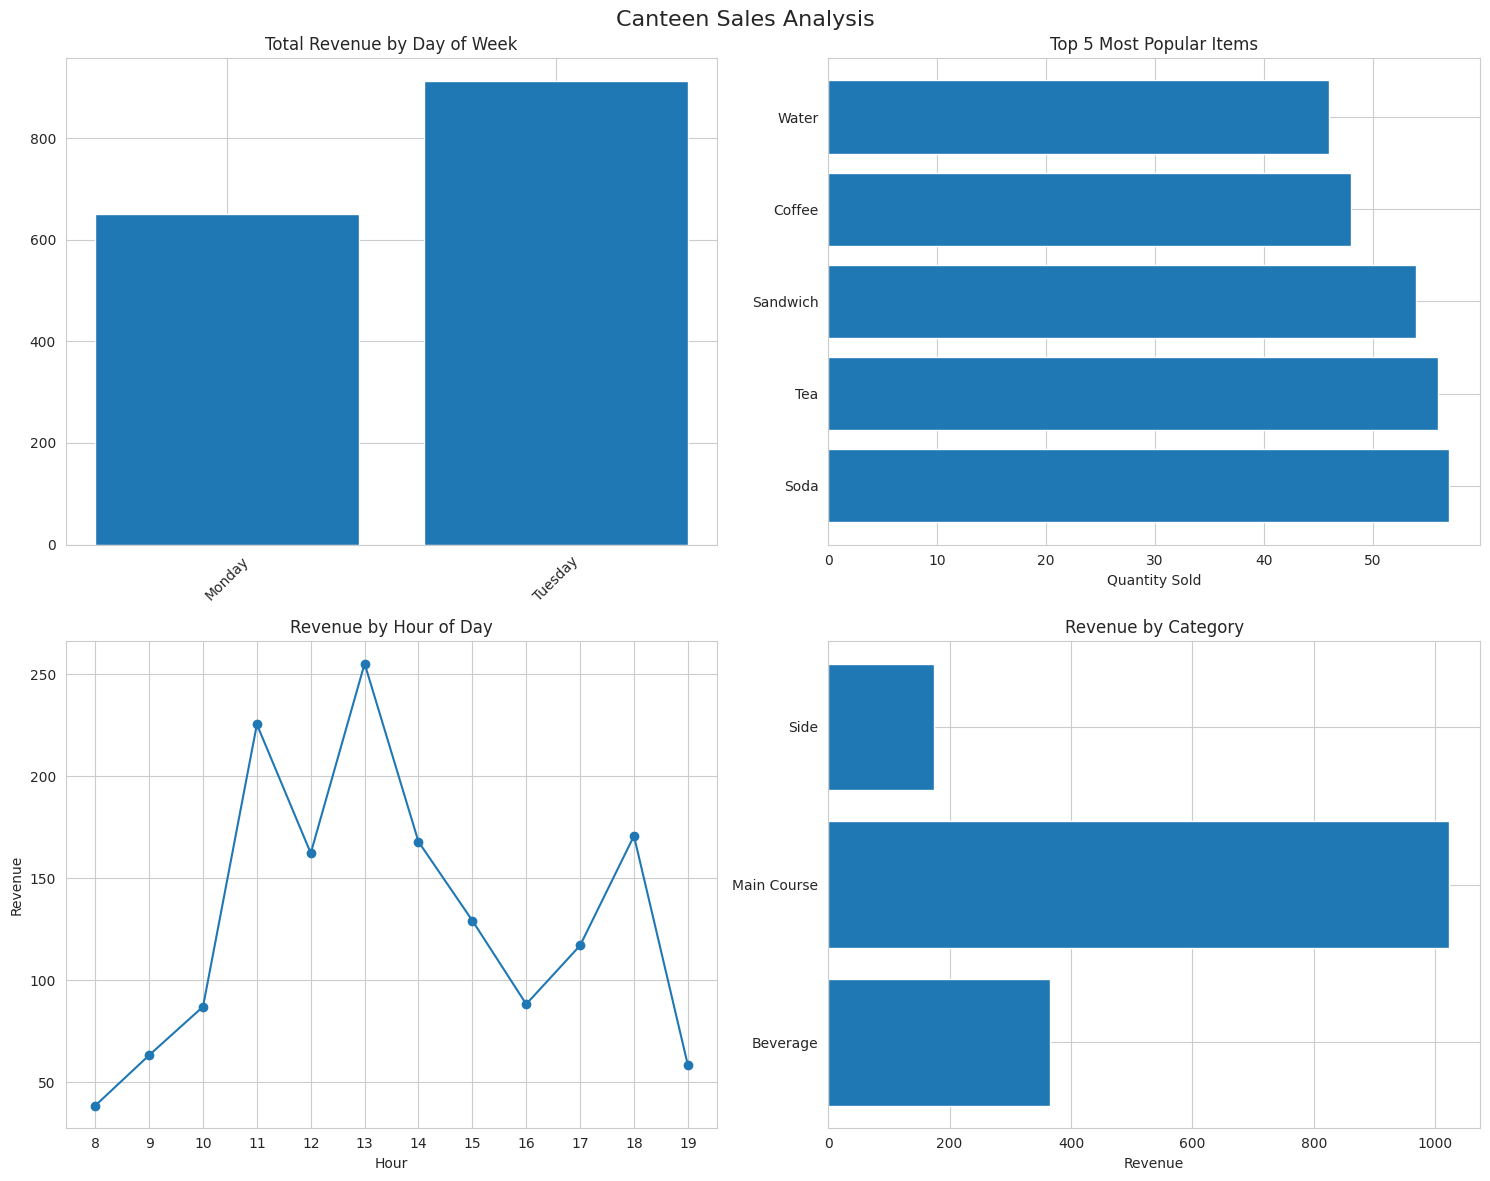

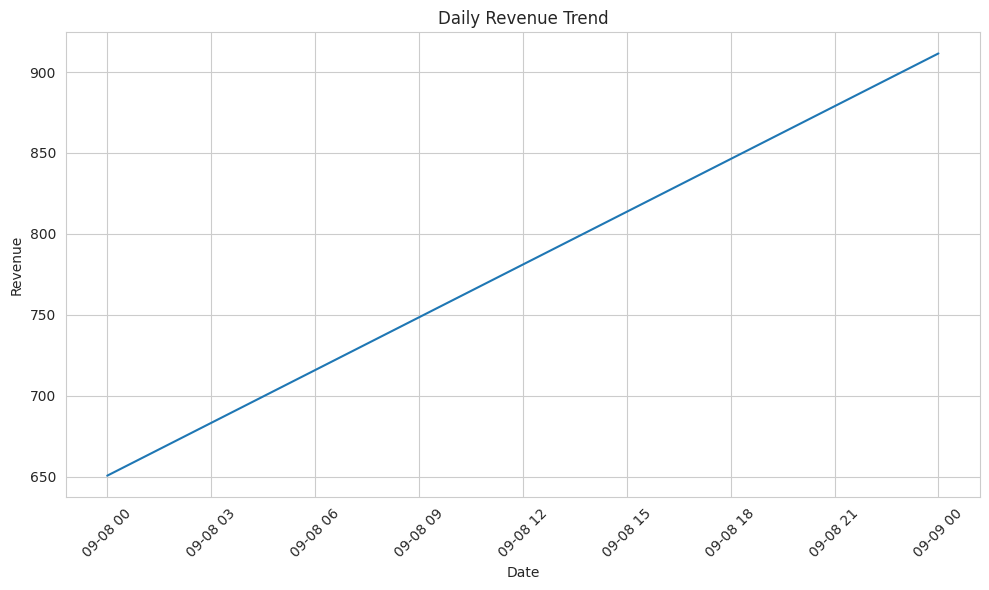


Please select an option:
1. Generate sample data
2. Show basic statistics
3. Create visualizations
4. Prepare data for Power BI
5. Exit


In [ ]:
# canteen_ordering_system.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import os

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

class CanteenOrderingSystem:
    def __init__(self):
        self.menu_items = {
            'Burger': {'category': 'Main Course', 'price': 5.99},
            'Pizza': {'category': 'Main Course', 'price': 7.50},
            'Sandwich': {'category': 'Main Course', 'price': 4.50},
            'Salad': {'category': 'Main Course', 'price': 6.25},
            'French Fries': {'category': 'Side', 'price': 2.99},
            'Onion Rings': {'category': 'Side', 'price': 3.25},
            'Soda': {'category': 'Beverage', 'price': 1.99},
            'Coffee': {'category': 'Beverage', 'price': 2.25},
            'Tea': {'category': 'Beverage', 'price': 1.75},
            'Water': {'category': 'Beverage', 'price': 1.00}
        }
        self.df = None

    def generate_data(self, days=30):
        """Generate simulated canteen order data"""
        print("Generating canteen order data...")

        # Generate orders
        orders = []
        order_id = 1000
        start_date = datetime.now() - timedelta(days=days)

        for day in range(days):
            current_date = start_date + timedelta(days=day)

            # More orders during lunch hours (11 AM - 2 PM)
            for hour in range(8, 20):  # 8 AM to 8 PM
                hour_probability = 0.3  # Base probability
                if 11 <= hour < 14:  # Lunch rush
                    hour_probability = 0.8

                # Generate orders for this hour
                num_orders = np.random.poisson(10 * hour_probability)

                for _ in range(num_orders):
                    order_time = current_date + timedelta(
                        hours=hour,
                        minutes=np.random.randint(0, 60)
                    )

                    # Select random items
                    num_items = np.random.randint(1, 5)
                    items = random.sample(list(self.menu_items.keys()), num_items)

                    for item in items:
                        orders.append({
                            'order_id': order_id,
                            'date': order_time.date(),
                            'time': order_time.time(),
                            'day_of_week': order_time.strftime('%A'),
                            'hour': hour,
                            'item': item,
                            'category': self.menu_items[item]['category'],
                            'price': self.menu_items[item]['price'],
                            'quantity': np.random.randint(1, 4)
                        })

                    order_id += 1

        # Create DataFrame
        self.df = pd.DataFrame(orders)
        self.df['revenue'] = self.df['price'] * self.df['quantity']

        print(f"Generated {len(self.df)} orders across {days} days")
        return self.df

    def show_basic_stats(self):
        """Display basic statistics about the canteen data"""
        if self.df is None:
            print("No data available. Please generate data first.")
            return

        print("=" * 50)
        print("CANTEEN ORDERING SYSTEM - BASIC STATISTICS")
        print("=" * 50)

        # Calculate basic metrics
        total_revenue = self.df['revenue'].sum()
        total_orders = self.df['order_id'].nunique()
        avg_order_value = total_revenue / total_orders
        items_per_order = self.df.groupby('order_id')['quantity'].sum().mean()

        print(f"Total Revenue: ${total_revenue:,.2f}")
        print(f"Total Orders: {total_orders}")
        print(f"Average Order Value: ${avg_order_value:.2f}")
        print(f"Average Items per Order: {items_per_order:.2f}")

        # Popular items
        popular_items = self.df.groupby('item')['quantity'].sum().sort_values(ascending=False).head(5)
        print("\nTop 5 Most Popular Items:")
        for i, (item, qty) in enumerate(popular_items.items(), 1):
            print(f"{i}. {item}: {qty} units")

        # Revenue by category
        category_revenue = self.df.groupby('category')['revenue'].sum().sort_values(ascending=False)
        print("\nRevenue by Category:")
        for category, revenue in category_revenue.items():
            print(f"- {category}: ${revenue:,.2f}")

    def visualize_data(self):
        """Create visualizations of the canteen data"""
        if self.df is None:
            print("No data available. Please generate data first.")
            return

        print("Creating visualizations...")

        # Create a 2x2 grid of plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Canteen Sales Analysis', fontsize=16)

        # 1. Revenue by day of week
        daily_revenue = self.df.groupby('day_of_week')['revenue'].sum()
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_revenue = daily_revenue.reindex(days)
        axes[0, 0].bar(daily_revenue.index, daily_revenue.values)
        axes[0, 0].set_title('Total Revenue by Day of Week')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. Most popular items
        popular_items = self.df.groupby('item')['quantity'].sum().sort_values(ascending=False).head(5)
        axes[0, 1].barh(list(popular_items.index), popular_items.values)
        axes[0, 1].set_title('Top 5 Most Popular Items')
        axes[0, 1].set_xlabel('Quantity Sold')

        # 3. Sales by hour
        hourly_sales = self.df.groupby('hour')['revenue'].sum()
        axes[1, 0].plot(hourly_sales.index, hourly_sales.values, marker='o')
        axes[1, 0].set_title('Revenue by Hour of Day')
        axes[1, 0].set_xlabel('Hour')
        axes[1, 0].set_ylabel('Revenue')
        axes[1, 0].set_xticks(range(8, 20))

        # 4. Revenue by category
        category_revenue = self.df.groupby('category')['revenue'].sum()
        axes[1, 1].barh(list(category_revenue.index), category_revenue.values)
        axes[1, 1].set_title('Revenue by Category')
        axes[1, 1].set_xlabel('Revenue')

        plt.tight_layout()
        plt.savefig('canteen_sales_analysis.png', dpi=300, bbox_inches='tight')
        print("Visualizations saved as 'canteen_sales_analysis.png'")

        # Show additional visualizations in separate figures
        plt.figure(figsize=(10, 6))

        # Daily revenue trend
        daily_trend = self.df.groupby('date')['revenue'].sum()
        plt.plot(daily_trend.index, daily_trend.values)
        plt.title('Daily Revenue Trend')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('daily_revenue_trend.png', dpi=300, bbox_inches='tight')

        plt.show()

    def prepare_powerbi_data(self):
        """Prepare data for Power BI dashboard"""
        if self.df is None:
            print("No data available. Please generate data first.")
            return

        print("Preparing data for Power BI...")

        # Create additional aggregated datasets for Power BI
        # Daily summary
        daily_summary = self.df.groupby('date').agg({
            'order_id': 'nunique',
            'revenue': 'sum',
            'quantity': 'sum'
        }).reset_index()
        daily_summary.rename(columns={'order_id': 'orders_count'}, inplace=True)

        # Category daily performance
        category_daily = self.df.groupby(['date', 'category']).agg({
            'revenue': 'sum',
            'quantity': 'sum'
        }).reset_index()

        # Item performance
        item_performance = self.df.groupby('item').agg({
            'revenue': 'sum',
            'quantity': 'sum',
            'order_id': 'nunique'
        }).reset_index()
        item_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

        # Hourly performance
        hourly_performance = self.df.groupby('hour').agg({
            'revenue': 'sum',
            'order_id': 'nunique',
            'quantity': 'sum'
        }).reset_index()
        hourly_performance.rename(columns={'order_id': 'orders_count'}, inplace=True)

        # Save data for Power BI
        self.df.to_csv('canteen_orders.csv', index=False)
        daily_summary.to_csv('canteen_daily_summary.csv', index=False)
        category_daily.to_csv('canteen_category_daily.csv', index=False)
        item_performance.to_csv('canteen_item_performance.csv', index=False)
        hourly_performance.to_csv('canteen_hourly_performance.csv', index=False)

        print("Data exported for Power BI:")
        print("- canteen_orders.csv")
        print("- canteen_daily_summary.csv")
        print("- canteen_category_daily.csv")
        print("- canteen_item_performance.csv")
        print("- canteen_hourly_performance.csv")
        print("\nYou can now import these files into Power BI to create dashboards.")

    def run(self):
        """Main application loop"""
        print("=" * 50)
        print("CANTEEN ORDERING SYSTEM ANALYSIS")
        print("=" * 50)

        while True:
            print("\nPlease select an option:")
            print("1. Generate sample data")
            print("2. Show basic statistics")
            print("3. Create visualizations")
            print("4. Prepare data for Power BI")
            print("5. Exit")

            choice = input("\nEnter your choice (1-5): ").strip()

            if choice == '1':
                try:
                    days = int(input("Enter number of days to generate (default 30): ") or "30")
                    self.generate_data(days)
                    print("Data generation completed successfully!")
                except ValueError:
                    print("Please enter a valid number.")

            elif choice == '2':
                self.show_basic_stats()

            elif choice == '3':
                self.visualize_data()

            elif choice == '4':
                self.prepare_powerbi_data()

            elif choice == '5':
                print("Thank you for using the Canteen Ordering System Analysis!")
                break

            else:
                print("Invalid choice. Please try again.")

# Run the application
if __name__ == "__main__":
    # Create output directory if it doesn't exist
    if not os.path.exists('output'):
        os.makedirs('output')

    # Change to output directory
    os.chdir('output')

    # Run the application
    app = CanteenOrderingSystem()
    app.run()4
